# Αναλύουμε τα δεδομένα που συλλέξαμε από το twitter του Skai, του In.gr και του Efsyn. Η συλλογή τους πραγματοποιήθηκε από το Workbench

# Εισάγουμε τις απαραίτητες βιβλιοθήκες

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import ast
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from sklearn.feature_extraction.text import CountVectorizer

## Εισάγουμε τα δεδομένα μας

In [11]:
skaidf= pd.read_csv('https://raw.githubusercontent.com/stavrouk/Stavrou_Teliki_Ergasia/main/Twitter/Skai%20Twitter.csv')
indf= pd.read_csv('https://raw.githubusercontent.com/stavrouk/Stavrou_Teliki_Ergasia/main/Twitter/In%20Twitter.csv')
efsyndf= pd.read_csv('https://raw.githubusercontent.com/stavrouk/Stavrou_Teliki_Ergasia/main/Twitter/Efsyn%20Twitter.csv')


In [12]:
len(skaidf)

321

In [13]:
len(indf)

175

In [14]:
len(efsyndf)

61

In [15]:
skai_tweets = skaidf[['created_at','text']]
skai_tweets = skai_tweets.rename(columns={'created_at': 'date', 'text': 'text'})

In [16]:
in_tweets = indf[['created_at','text']]
in_tweets = in_tweets.rename(columns={'created_at': 'date', 'text': 'text'})

In [17]:
efsyn_tweets = efsyndf[['created_at','text']]
efsyn_tweets = efsyn_tweets.rename(columns={'created_at': 'date', 'text': 'text'})

### Μετατρέπουμε την ημερομηνία σε Datetime

In [18]:
skai_tweets['date'] = pd.to_datetime(skai_tweets['date'], format='%Y-%m-%d')
in_tweets['date'] = pd.to_datetime(in_tweets['date'], format='%Y-%m-%d')
efsyn_tweets['date'] = pd.to_datetime(efsyn_tweets['date'], format='%Y-%m-%d')

In [19]:
skai_tweets.dtypes

date    datetime64[ns]
text            object
dtype: object

In [20]:
in_tweets.dtypes

date    datetime64[ns]
text            object
dtype: object

In [21]:
efsyn_tweets.dtypes

date    datetime64[ns]
text            object
dtype: object

In [22]:
skai_tweets['text'] = skai_tweets['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ")
in_tweets['text'] = in_tweets['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ")
efsyn_tweets['text'] = efsyn_tweets['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ")

In [23]:
skai_tweets.head()

,date,text
0,2021-06-30,Αλλάζει τακτική στους εμβολιασμούς η Γερμανία ...
1,2021-06-30,Κορωνοϊός: Το Ελσίνκι θα χορηγήσει εμβόλια σε ...
2,2021-06-30,Συγκινεί 7χρονη με υποκείμενο νόσημα από τη Δρ...
3,2021-06-30,Βρετανία: Χωρίς πιστοποιητικά εμβολιασμού τελι...
4,2021-06-30,Κικίλιας: Από 6 Ιουλίου ξεκινούν οι εμβολιασμο...


In [24]:
in_tweets.head()

,date,text
0,2021-06-30,Valvena SE: Το εμβόλιο που εξετάζει η ΕΕ
1,2021-06-30,Θεσσαλονίκη: Γυναίκα κατέρρευσε στο προαύλιο ν...
2,2021-06-30,Κικίλιας: Από 6 Ιουλίου ξεκινούν οι εμβολιασμο...
3,2021-06-30,Δράμα: 7χρονη με υποκείμενο νόσημα απευθύνει έ...
4,2021-06-30,Κοροναϊός: Η μετάλλαξη Δέλτα «χτυπά» και τα πα...


In [25]:
efsyn_tweets.head()

,date,text
0,2021-06-30,Από τα δωρεάν self test αποκλείονται πλέον όσο...
1,2021-06-30,Με το χαρακτηριστικό του ύφος κούνησε το δάχτυ...
2,2021-06-30,"Αφορά πλήρη εμβολιασμό, νόσηση ή αρνητικό τεστ..."
3,2021-06-30,Το θέμα της πανδημίας και του εμβολιασμού κυρι...
4,2021-06-30,Με το χαρτζιλίκι στους εμβολιασμένους νέους ο ...


### Εισάγουμε το Ελληνικό λεξικό

In [26]:
import spacy

In [27]:
#!python -m spacy download el_core_news_sm

In [28]:
nlp = spacy.load('el_core_news_sm')

## Διαβάζουμε το EmoLex και πραγματοποιούμε το Sentiment Analysis

In [29]:
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

In [32]:
emolex_df.tail()

,index,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13156,13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13157,13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13158,13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13159,13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13160,13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

In [34]:
matrix1 = vec.fit_transform(skai_tweets['text'])
vocab1 = vec.get_feature_names()
wordcount_df1 = pd.DataFrame(matrix1.toarray(), columns=vocab1)
wordcount_df1.head()

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
matrix2 = vec.fit_transform(in_tweets['text'])
vocab2 = vec.get_feature_names()
wordcount_df2 = pd.DataFrame(matrix2.toarray(), columns=vocab2)
wordcount_df2.head()

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
matrix3 = vec.fit_transform(efsyn_tweets['text'])
vocab3 = vec.get_feature_names()
wordcount_df3 = pd.DataFrame(matrix3.toarray(), columns=vocab3)
wordcount_df3.head()

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
wordcount_df1.shape

(321, 13161)

In [38]:
wordcount_df2.shape

(175, 13161)

In [39]:
wordcount_df3.shape

(61, 13161)

## Φτιάχνουμε λίστες με τις λέξεις που θα χρησιμοποιήσουμε για το Sentiment Analysis

In [40]:
angry_words = emolex_df[emolex_df.Anger == 1]['word']

positive_words = emolex_df[emolex_df.Positive == 1]['word']

sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

negative_words = emolex_df[emolex_df.Negative == 1]['word']

joy_words = emolex_df[emolex_df.Joy == 1]['word']

trust_words = emolex_df[emolex_df.Trust == 1]['word']

fear_words = emolex_df[emolex_df.Fear == 1]['word']

## Δημιουργούμε νέες στήλες στα Dataframes με τις λέξεις που θα χρησιμοποιήσουμε στο Sentiment Analysis

In [41]:
skai_tweets['anger'] = wordcount_df1[angry_words].sum(axis=1)

skai_tweets['positivity'] = wordcount_df1[positive_words].sum(axis=1)

skai_tweets['joy'] = wordcount_df1[joy_words].sum(axis=1)

skai_tweets['disgust'] = wordcount_df1[disgust_words].sum(axis=1)

skai_tweets['surprise'] = wordcount_df1[surprise_words].sum(axis=1)

skai_tweets['trust'] = wordcount_df1[trust_words].sum(axis=1)

skai_tweets['anticipation'] = wordcount_df1[anticipation_words].sum(axis=1)

skai_tweets['sadness'] = wordcount_df1[sadness_words].sum(axis=1)

skai_tweets['negative'] = wordcount_df1[negative_words].sum(axis=1)

skai_tweets['fear'] = wordcount_df1[fear_words].sum(axis=1)

In [42]:
in_tweets['anger'] = wordcount_df2[angry_words].sum(axis=1)

in_tweets['positivity'] = wordcount_df2[positive_words].sum(axis=1)

in_tweets['joy'] = wordcount_df2[joy_words].sum(axis=1)

in_tweets['disgust'] = wordcount_df2[disgust_words].sum(axis=1)

in_tweets['surprise'] = wordcount_df2[surprise_words].sum(axis=1)

in_tweets['trust'] = wordcount_df2[trust_words].sum(axis=1)

in_tweets['anticipation'] = wordcount_df2[anticipation_words].sum(axis=1)

in_tweets['sadness'] = wordcount_df2[sadness_words].sum(axis=1)

in_tweets['negative'] = wordcount_df2[negative_words].sum(axis=1)

in_tweets['fear'] = wordcount_df2[fear_words].sum(axis=1)

In [43]:
efsyn_tweets['anger'] = wordcount_df3[angry_words].sum(axis=1)

efsyn_tweets['positivity'] = wordcount_df3[positive_words].sum(axis=1)

efsyn_tweets['joy'] = wordcount_df3[joy_words].sum(axis=1)

efsyn_tweets['disgust'] = wordcount_df3[disgust_words].sum(axis=1)

efsyn_tweets['surprise'] = wordcount_df3[surprise_words].sum(axis=1)

efsyn_tweets['trust'] = wordcount_df3[trust_words].sum(axis=1)

efsyn_tweets['anticipation'] = wordcount_df3[anticipation_words].sum(axis=1)

efsyn_tweets['sadness'] = wordcount_df3[sadness_words].sum(axis=1)

efsyn_tweets['negative'] = wordcount_df3[negative_words].sum(axis=1)

efsyn_tweets['fear'] = wordcount_df3[fear_words].sum(axis=1)

In [44]:
skai_tweets.head()

,date,text,anger,positivity,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2021-06-30,Αλλάζει τακτική στους εμβολιασμούς η Γερμανία ...,0,0,0,0,0,1,0,0,0,1
1,2021-06-30,Κορωνοϊός: Το Ελσίνκι θα χορηγήσει εμβόλια σε ...,0,0,0,0,0,0,0,1,1,1
2,2021-06-30,Συγκινεί 7χρονη με υποκείμενο νόσημα από τη Δρ...,0,0,0,0,0,1,1,0,0,0
3,2021-06-30,Βρετανία: Χωρίς πιστοποιητικά εμβολιασμού τελι...,1,2,1,2,1,2,1,2,2,2
4,2021-06-30,Κικίλιας: Από 6 Ιουλίου ξεκινούν οι εμβολιασμο...,0,0,0,0,0,1,1,0,0,0


In [45]:
in_tweets.head()

,date,text,anger,positivity,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2021-06-30,Valvena SE: Το εμβόλιο που εξετάζει η ΕΕ,0,1,0,0,0,0,0,0,0,0
1,2021-06-30,Θεσσαλονίκη: Γυναίκα κατέρρευσε στο προαύλιο ν...,0,0,0,0,0,0,0,0,0,0
2,2021-06-30,Κικίλιας: Από 6 Ιουλίου ξεκινούν οι εμβολιασμο...,0,0,0,0,0,0,0,0,0,0
3,2021-06-30,Δράμα: 7χρονη με υποκείμενο νόσημα απευθύνει έ...,0,0,0,0,0,0,1,1,1,1
4,2021-06-30,Κοροναϊός: Η μετάλλαξη Δέλτα «χτυπά» και τα πα...,0,0,0,0,0,1,1,0,0,0


In [46]:
efsyn_tweets.head()

,date,text,anger,positivity,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2021-06-30,Από τα δωρεάν self test αποκλείονται πλέον όσο...,0,2,1,0,0,1,1,0,0,0
1,2021-06-30,Με το χαρακτηριστικό του ύφος κούνησε το δάχτυ...,1,1,0,0,0,2,0,0,1,1
2,2021-06-30,"Αφορά πλήρη εμβολιασμό, νόσηση ή αρνητικό τεστ...",0,0,0,0,0,0,0,0,0,0
3,2021-06-30,Το θέμα της πανδημίας και του εμβολιασμού κυρι...,0,0,0,0,0,0,0,0,0,0
4,2021-06-30,Με το χαρτζιλίκι στους εμβολιασμένους νέους ο ...,0,0,0,0,0,0,0,0,1,0


In [47]:
skai_tweets.set_index('date' , inplace=True)
in_tweets.set_index('date' , inplace=True)
efsyn_tweets.set_index('date' , inplace=True)

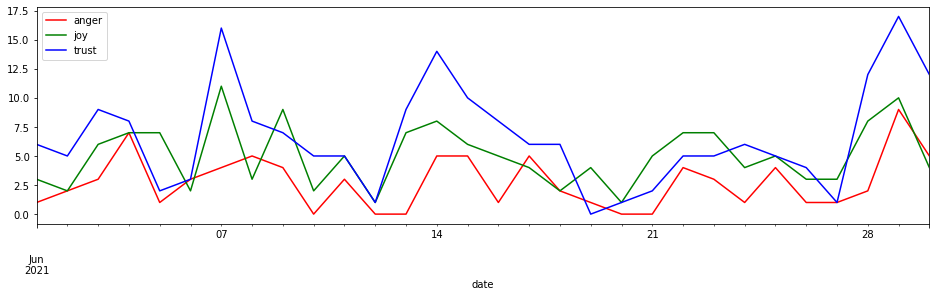

In [48]:
#Δημιουργούμε γράφημα με σύγκριση των συναισθημάτων θυμού, χαράς και εμπιστοσύνης από τις δημοσιεύσεις του Skai
ax = skai_tweets['anger'].resample('D').sum().plot(figsize=(16,4), color = 'red', label='anger')
skai_tweets['joy'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'green', label='joy')
skai_tweets['trust'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'blue', label='trust').legend()

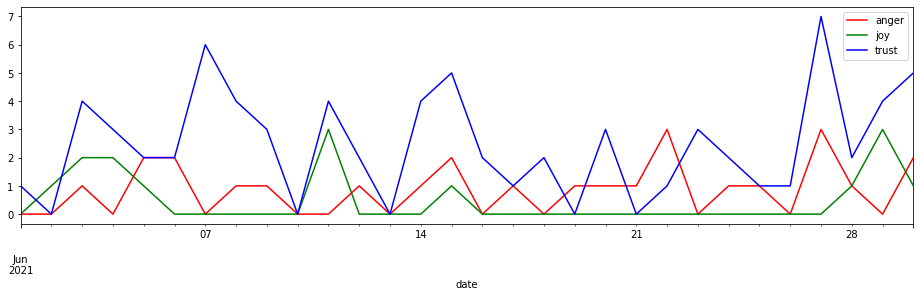

In [49]:
#Δημιουργούμε γράφημα με σύγκριση των συναισθημάτων θυμού, χαράς και εμπιστοσύνης από τις δημοσιεύσεις του In.gr
ax = in_tweets['anger'].resample('D').sum().plot(figsize=(16,4), color = 'red', label='anger')
in_tweets['joy'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'green', label='joy')
in_tweets['trust'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'blue', label='trust').legend()

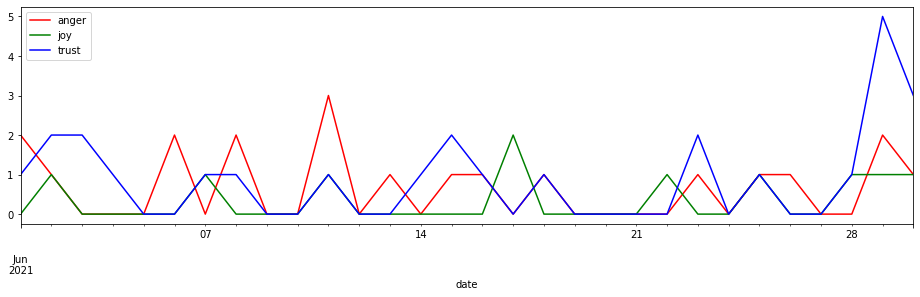

In [50]:
#Δημιουργούμε γράφημα με σύγκριση των συναισθημάτων θυμού, χαράς και εμπιστοσύνης από τις δημοσιεύσεις του Efsyn
ax = efsyn_tweets['anger'].resample('D').sum().plot(figsize=(16,4), color = 'red', label='anger')
efsyn_tweets['joy'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'green', label='joy')
efsyn_tweets['trust'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'blue', label='trust').legend()

Text(0.5, 1.0, 'Θετικότητα Δημοσιεύσεων')

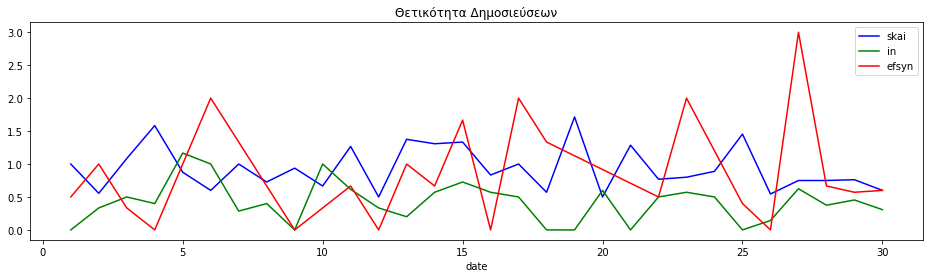

In [51]:
#Δημιουργούμε γράφημα παρουσιάζοντας το συναίσθημα της θετικότητας, συγκρίνοντας τις δημοσιεύσεις των 3 ειδησεογραφικών σελίδων
ax = skai_tweets['positivity'].groupby(by=skai_tweets.index.day).mean().plot(figsize=(16,4), 
                                                          color = 'blue', label='skai')
in_tweets['positivity'].groupby(by=in_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'in', color = 'g')
efsyn_tweets['positivity'].groupby(by=efsyn_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'efsyn',color = 'r').legend()
plt.title("Θετικότητα Δημοσιεύσεων")                                       

Text(0.5, 1.0, 'Αρνητικότητα Δημοσιεύσεων')

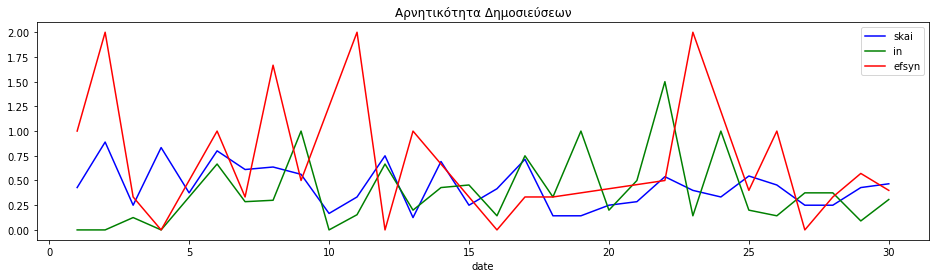

In [52]:
#Δημιουργούμε γράφημα παρουσιάζοντας το συναίσθημα της αρνητικότητας, συγκρίνοντας τις δημοσιεύσεις των 3 ειδησεογραφικών σελίδων
ax = skai_tweets['negative'].groupby(by=skai_tweets.index.day).mean().plot(figsize=(16,4), 
                                                          color = 'blue', label='skai')
in_tweets['negative'].groupby(by=in_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'in', color = 'g')
efsyn_tweets['negative'].groupby(by=efsyn_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'efsyn',color = 'r').legend()
plt.title("Αρνητικότητα Δημοσιεύσεων")                                                

In [53]:
plt.style.use('ggplot')

Text(0.5, 1.0, 'Θετικότητα Δημοσιεύσεων')

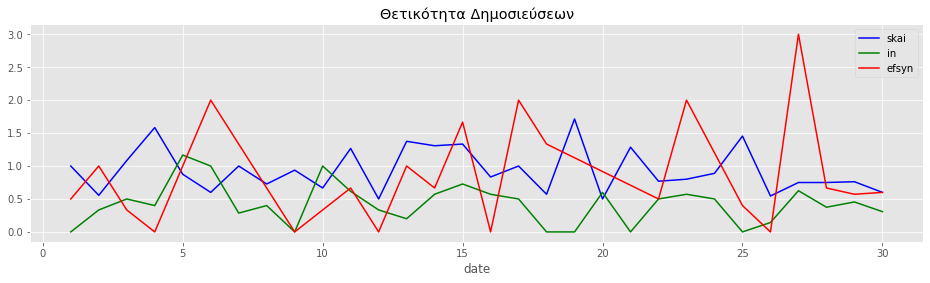

In [54]:
#Δημιουργούμε γράφημα παρουσιάζοντας το συναίσθημα της θετικότητας, συγκρίνοντας τις δημοσιεύσεις των 3 ειδησεογραφικών σελίδων
ax = skai_tweets['positivity'].groupby(by=skai_tweets.index.day).mean().plot(figsize=(16,4), 
                                                          color = 'blue', label='skai')
in_tweets['positivity'].groupby(by=in_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'in', color = 'g')
efsyn_tweets['positivity'].groupby(by=efsyn_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'efsyn',color = 'r').legend()
plt.title("Θετικότητα Δημοσιεύσεων")                                                 

Text(0.5, 1.0, 'Αρνητικότητα Δημοσιεύσεων')

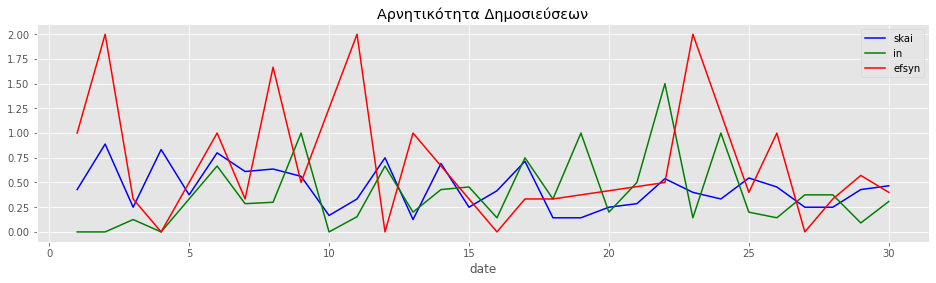

In [55]:
#Δημιουργούμε γράφημα παρουσιάζοντας το συναίσθημα της αρνητικότητας, συγκρίνοντας τις δημοσιεύσεις των 3 ειδησεογραφικών σελίδων
ax = skai_tweets['negative'].groupby(by=skai_tweets.index.day).mean().plot(figsize=(16,4), 
                                                          color = 'blue', label='skai')
in_tweets['negative'].groupby(by=in_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'in', color = 'g')
efsyn_tweets['negative'].groupby(by=efsyn_tweets.index.day).mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'efsyn',color = 'r').legend()
plt.title("Αρνητικότητα Δημοσιεύσεων")                                                 